In [ ]:
from google.colab import files
import zipfile
import os

# Step 1: Upload ZIP of dataset
uploaded = files.upload()  # This will open a file picker

# Step 2: Extract ZIP
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    with zipfile.ZipFile(fn, 'r') as zip_ref:
        zip_ref.extractall("/content/FER2013")

dataset_path = "/content/FER2013"  # now ready
train_dir = os.path.join(dataset_path, "train")
val_dir   = os.path.join(dataset_path, "test")


Saving FER2013.zip to FER2013.zip
User uploaded file "FER2013.zip" with length 63252113 bytes


In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # EfficientNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(val_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Classes:", train_dataset.classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.efficientnet_b0(pretrained=True)

# classifier head
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)


Using device: cuda
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 20.5M/20.5M [00:00<00:00, 241MB/s]


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)


In [ ]:
epochs = 25

for epoch in range(1, epochs+1):
    # TRAIN
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100 * correct / total

    # VALIDATE
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100 * correct / total

    # Step the scheduler
    scheduler.step(val_loss / len(val_loader))

    print(f"Epoch [{epoch}/{epochs}] | "
          f"Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%")


Epoch [1/25] | Train Loss: 1.2653 | Train Acc: 52.23% | Val Loss: 1.0245 | Val Acc: 60.49%
Epoch [2/25] | Train Loss: 0.9870 | Train Acc: 63.10% | Val Loss: 0.9522 | Val Acc: 64.75%
Epoch [3/25] | Train Loss: 0.8835 | Train Acc: 67.01% | Val Loss: 0.9042 | Val Acc: 66.59%
Epoch [4/25] | Train Loss: 0.7983 | Train Acc: 70.42% | Val Loss: 0.8987 | Val Acc: 66.79%
Epoch [5/25] | Train Loss: 0.7246 | Train Acc: 73.44% | Val Loss: 0.8882 | Val Acc: 68.07%
Epoch [6/25] | Train Loss: 0.6514 | Train Acc: 76.27% | Val Loss: 0.9151 | Val Acc: 68.21%
Epoch [7/25] | Train Loss: 0.5831 | Train Acc: 78.84% | Val Loss: 0.9117 | Val Acc: 68.85%
Epoch [8/25] | Train Loss: 0.5193 | Train Acc: 80.95% | Val Loss: 0.9589 | Val Acc: 68.97%
Epoch [9/25] | Train Loss: 0.4608 | Train Acc: 83.22% | Val Loss: 0.9925 | Val Acc: 68.89%
Epoch [10/25] | Train Loss: 0.3600 | Train Acc: 87.17% | Val Loss: 1.0514 | Val Acc: 69.95%
Epoch [11/25] | Train Loss: 0.3194 | Train Acc: 88.59% | Val Loss: 1.0985 | Val Acc: 69.8

In [ ]:
torch.save(model.state_dict(), "/content/emotion_cnn.pth")
print("Model saved to /content/emotion_cnn.pth")


Model saved to /content/emotion_cnn.pth


In [ ]:
from PIL import Image
from google.colab import files
import torch
import torchvision.transforms as transforms

# SAME AS TRAINING TRANSFORM
inference_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3-channel
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def predict_image(model, img_path):
    model.eval()
    img = Image.open(img_path).convert("RGB")
    img = inference_transform(img).unsqueeze(0).to(device)  # [1,3,224,224]

    with torch.no_grad():
        output = model(img)
        predicted = torch.argmax(output, dim=1).item()

    return emotion_labels[predicted]

# Upload a new image for prediction
uploaded_img = files.upload()

for fn in uploaded_img.keys():
    prediction = predict_image(model, fn)
    print(f"Predicted emotion for {fn}: {prediction}")


Saving photo.jpg to photo (1).jpg
Predicted emotion for photo (1).jpg: sad


CALCULATING EVAL METRICES AND GRAPHS

In [ ]:
# ============================================================
# 1) UPLOAD TRAINED MODEL (emotion_cnn.pth)
# ============================================================
from google.colab import files
uploaded = files.upload()

import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load EfficientNet
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 7)

model.load_state_dict(torch.load("emotion_cnn.pth", map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")


Saving emotion_cnn.pth to emotion_cnn.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully!


In [ ]:
# ============================================================
# 2) LOAD TEST/VALIDATION DATA
# ============================================================
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

dataset_path = "/content/FER2013"
val_dir = os.path.join(dataset_path, "test")

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

val_dataset = datasets.ImageFolder(val_dir, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = val_dataset.classes
print("Classes:", class_names)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [ ]:
# ============================================================
# 3) METRICS: ACCURACY, PRECISION, RECALL, F1, CONFUSION MATRIX
# ============================================================
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

print("\n====== CLASSIFICATION REPORT ======\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
print("\n====== CONFUSION MATRIX ======\n")
print(cm)



====== CLASSIFICATION REPORT ======

              precision    recall  f1-score   support

       angry       0.61      0.63      0.62       958
     disgust       0.84      0.72      0.78       111
        fear       0.58      0.54      0.56      1024
       happy       0.89      0.87      0.88      1774
     neutral       0.64      0.66      0.65      1233
         sad       0.57      0.57      0.57      1247
    surprise       0.80      0.85      0.82       831

    accuracy                           0.70      7178
   macro avg       0.70      0.69      0.70      7178
weighted avg       0.70      0.70      0.70      7178


====== CONFUSION MATRIX ======

[[ 604    9   93   34   80  119   19]
 [  18   80    3    2    3    4    1]
 [ 105    3  556   17   86  180   77]
 [  36    0   31 1544   79   41   43]
 [  79    2   75   73  810  177   17]
 [ 131    1  153   41  192  712   17]
 [  21    0   47   26   18   15  704]]


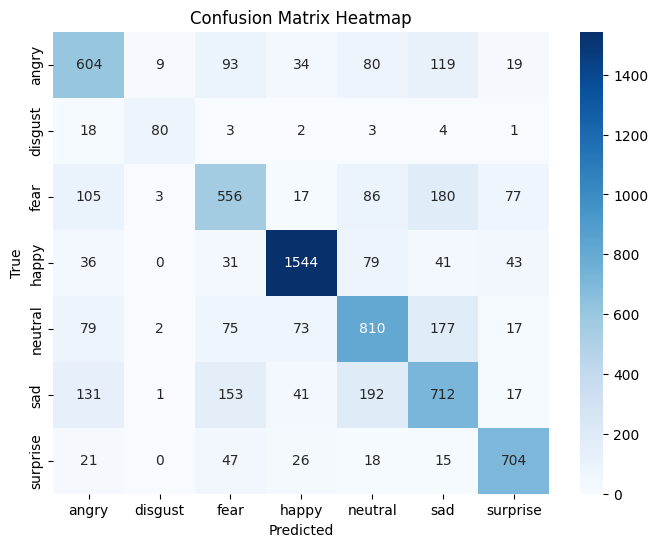

In [ ]:
# ============================================================
# 4) PLOT CONFUSION MATRIX HEATMAP
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()


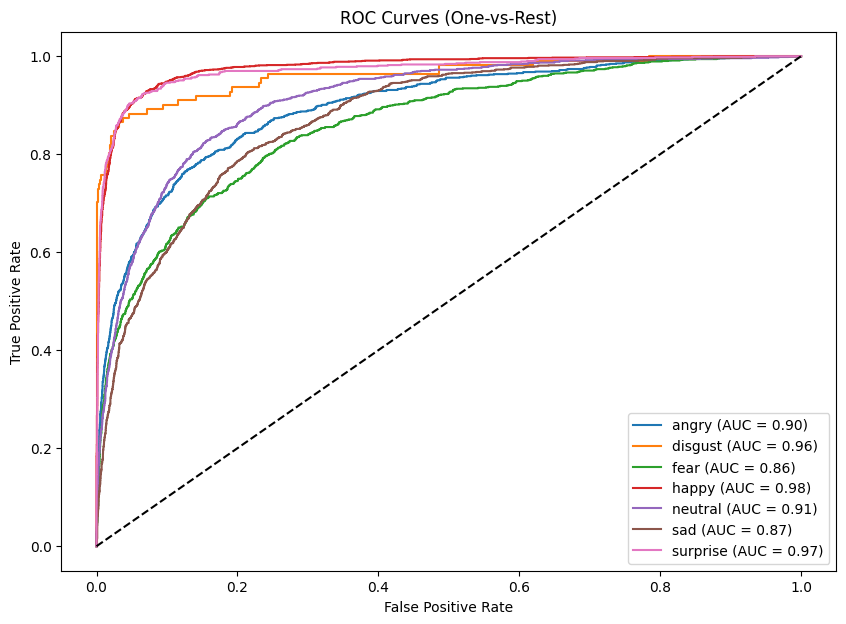

In [ ]:
# ============================================================
# 6) ROC CURVES (ONE VS REST)
# ============================================================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize labels for ROC
y_test_bin = label_binarize(all_labels, classes=range(7))

plt.figure(figsize=(10,7))

for i in range(7):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.show()
